### Processing user-game data

In [1]:
import gzip

def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [2]:
df_ui = parse('australian_users_items.json.gz')

In [3]:
review_data = parse('australian_user_reviews.json.gz')


In [4]:
ui_dict = {}

In [5]:
for d in df_ui:
    ui_dict[int(d['steam_id'])] = [{'game_id': int(item['item_id']), 'play_time': item['playtime_forever']} for item in d['items']]

In [6]:
import json

with open('ui_dict.json', 'w') as js:
    json.dump(ui_dict, js)

### Processing game data

In [7]:
df_games = parse('steam_games.json.gz')

In [8]:
from collections import defaultdict
tags = []
game_id_dict = defaultdict(list)
for d in df_games:
    if 'id' in d:
        if 'genres' in d:
            for genre in d['genres']:
                if genre not in tags:
                    tags.append(genre)
        if 'specs' in d:
            for spec in d['specs']:
                if spec not in tags:
                    tags.append(spec)

In [9]:
"""Turn game id to 1-hot vectors"""

df_games = parse('steam_games.json.gz')
num_tags = len(tags)
for d in df_games:
    if 'id' in d:
        game_id = int(d['id'])

        vec_1hot = [0]*num_tags
        if 'genres' in d:
            for genre in d['genres']:
                vec_1hot[tags.index(genre)] = 1

        if 'specs' in d:
            for spec in d['specs']:
                vec_1hot[tags.index(spec)] = 1

        game_id_dict[game_id] = vec_1hot


In [10]:
with open('game_tags.json', 'w') as js:
    json.dump({'tags': tags}, js)

In [11]:
with open('game_dict.json', 'w') as js:
    json.dump(game_id_dict, js)

### Customer Embedding

In [12]:
import numpy as np

user_history = {}
user_y = {}
user_u = {}
user_type = {}
user_x = {}
EPSILON = 0.1
# {user_id: history \in (53, T)}
for user in ui_dict:
    if len(ui_dict[user]) == 0:
        continue
    user_history[user] = []
    user_type[user] = []
    user_type[user] = np.zeros(num_tags)
    total_time = 0
    user_y[user] = []
    user_x[user] = []
    user_u[user] = []
    
    for i,game_dict in enumerate(ui_dict[user]):
        x = 0
        if game_dict['game_id'] in game_id_dict:
            user_history[user].append( game_id_dict[game_dict['game_id']] )
            user_type[user] += np.array(game_id_dict[game_dict['game_id']])*game_dict['play_time']
            total_time += game_dict['play_time']
            
            # x = user_x[user][-1]
            if total_time != 0:
                y = user_type[user]/total_time
                y_sum = y.sum()    
                if y_sum != 0:
                    y /= y_sum
            else:
                y = np.zeros(num_tags)
            u = np.array(game_id_dict[game_dict['game_id']])
            
            if np.linalg.norm(y) != 0 and np.linalg.norm(u) != 0:
                x = x + EPSILON* np.dot(y, u)/(np.linalg.norm(y)*np.linalg.norm(u))
            user_x[user].append( x )
            user_y[user].append( y )
            user_u[user].append( u )
            
            
    user_history[user] = np.array(user_history[user])
    
    if total_time != 0:
        user_type[user] /= total_time
    user_type_sum = user_type[user].sum()    
    if user_type_sum != 0:
        user_type[user] /= user_type_sum



In [13]:
from sklearn.cluster import KMeans
USER_TYPE_CNT = 10

user_matrix = []
for user in user_type:
    user_matrix.append(user_type[user])    
user_matrix = np.array(user_matrix)

In [14]:
import pickle

kmeans = KMeans(n_clusters=USER_TYPE_CNT, random_state=0).fit(user_matrix)

with open(f'km_model.pickle', 'wb') as pk:
    pickle.dump(kmeans, pk, protocol=pickle.HIGHEST_PROTOCOL) 

In [15]:
user_class = {}
for user in user_type:
    user_data = np.array(user_type[user]).reshape(1, -1)
    k = kmeans.predict(user_data)
    user_class[user] = k

In [16]:
user_type_cnt = np.zeros(USER_TYPE_CNT)
for user in user_type:
    user_type_cnt[user_class[user][0]] += 1
    

1409.0


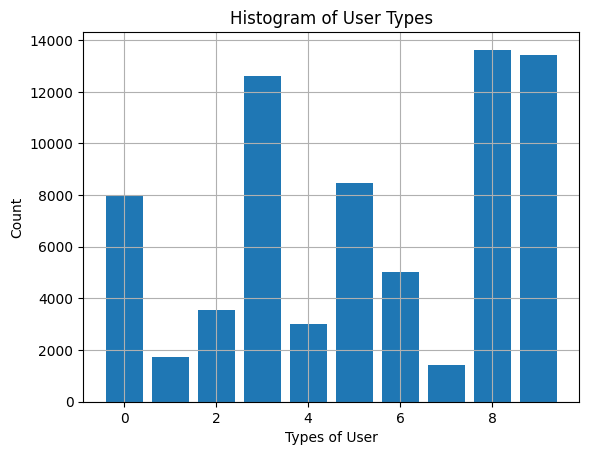

In [17]:
import matplotlib.pyplot as plt
print(user_type_cnt.min())
# n, bins, patches = plt.hist(user_type_cnt, 100, density=False, facecolor='g', alpha=0.75)
X = np.arange(USER_TYPE_CNT)
plt.bar(X, user_type_cnt)
plt.xlabel('Types of User')
plt.ylabel('Count')
plt.title('Histogram of User Types')
plt.grid(True)
plt.show()

In [18]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(user_matrix)

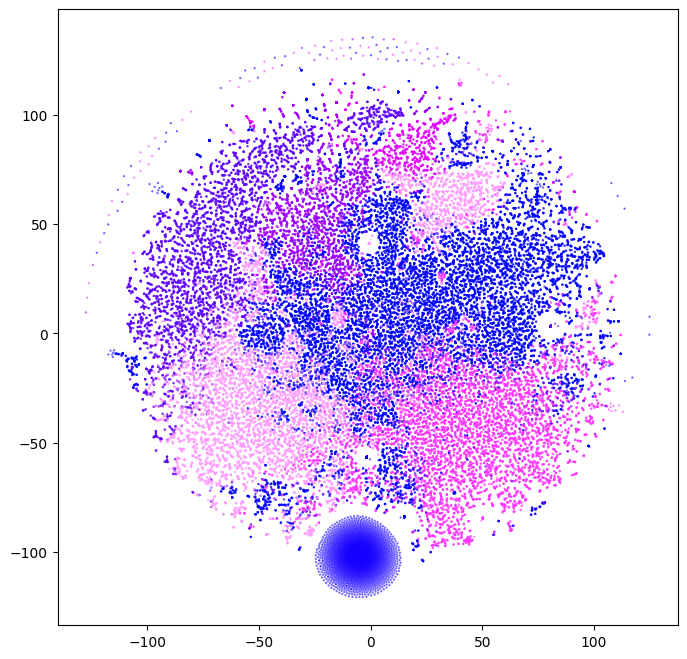

In [19]:
import matplotlib.cm as cm

fig, axs = plt.subplots(figsize=(8, 8), dpi=100)
color_list = []
for user in user_class:
    cm_user = cm.hot(user_class[user][0]/float(USER_TYPE_CNT))
    color_list.append(cm_user[1:])
axs.scatter(X_embedded[:, 0], X_embedded[:, 1], s=0.5, c=color_list, alpha=0.5)


In [20]:

preprocessing_res = {
    'user_type': user_type,
    'user_class': user_class,
    'user_type_cnt': user_type_cnt,
    '2embed': X_embedded,
    'tags_cnt': num_tags,
    'user_matrix': user_matrix,
    'user_history': user_history,
    'ui_dict': ui_dict,
    'game_dict': game_dict
}


with open(f'preprocessing.pickle', 'wb') as pk:
    pickle.dump(preprocessing_res, pk, protocol=pickle.HIGHEST_PROTOCOL) 

    

In [21]:
with open(f'dimension.pickle', 'wb') as pk:
    pickle.dump({'tages': num_tags, 'users': USER_TYPE_CNT}, pk, protocol=pickle.HIGHEST_PROTOCOL) 

In [22]:

data_res = {
    'x': user_x,
    'y': user_y,
    'u': user_u
}

with open(f'data_res.pickle', 'wb') as pk:
    pickle.dump(data_res, pk, protocol=pickle.HIGHEST_PROTOCOL)